# Notebook demonstrating a simple approach to infer cosmology from XOD diagrams

In [1]:
!python -c "import jax; print(jax.default_backend(), jax.devices())"
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.75' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util, value_and_grad
from jax.tree_util import tree_map

import tqdm
import optax
import flax.linen as nn
# from flax.metrics import tensorboard
from jax_resnet import resnet
from functools import partial
from getdist import plots, MCSamples

import sbi_lens
import haiku as hk

%matplotlib inline
%load_ext autoreload 
%autoreload 2
import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Model SBI")
from montecosmo.utils import pickle_dump, pickle_load, get_vlim, theme_switch, sample_and_save, load_runs
save_dir = os.path.expanduser("~/scratch/pickles/")

gpu [cuda(id=0)]


2024-04-17 15:11:43.941257: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Simulate

In [32]:
from montecosmo.models import pmrsd_model, prior_model, get_logp_fn, get_score_fn, get_simulator, get_pk_fn, get_param_fn, get_noise_fn
from montecosmo.models import print_config, condition_on_config_mean, default_config as config
# Build and render model
config.update(a_lpt=0.5, mesh_size=16*np.ones(3, dtype=int), 
              trace_reparam=True, lik_config={'obs_std':0.})
model = partial(pmrsd_model, **config)
print_config(model)
simulator = jit(vmap(get_simulator(model)))

# Get fiducial parameters
fiduc_model = partial(model, trace_reparam=True) # lik_config={'obs_std':0.1}
fiduc_params = get_simulator(condition_on_config_mean(fiduc_model))(rng_seed=0)

param_fn = get_param_fn(**config)
param_vfn = jit(vmap(param_fn))

# CONFIG
{'mesh_size': array([16, 16, 16]), 'box_size': array([640., 640., 640.]), 'a_lpt': 0.5, 'a_obs': 0.5, 'galaxy_density': 0.001, 'trace_reparam': True, 'trace_meshes': False, 'prior_config': {'Omega_c': ['{\\Omega}_c', 0.25, 0.1], 'sigma8': ['{\\sigma}_8', 0.831, 0.14], 'b1': ['{b}_1', 1.0, 0.5], 'b2': ['{b}_2', 0.0, 0.5], 'bs2': ['{b}_{s^2}', 0.0, 0.5], 'bn2': ['{b}_{\\nabla^2}', 0.0, 0.5]}, 'lik_config': {'obs_std': 0.0}}

# INFOS
cell_size:        [40.0, 40.0, 40.0] Mpc/h
delta_k:          0.00982 h/Mpc
k_nyquist:        0.07854 h/Mpc
mean_gxy_density: 64.000 gxy/cell



/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

In [33]:
n_simus = 10_000
obs_name = ['obs_mesh']
lat_name = ['Omega_c','sigma8']
simus = simulator(rng_seed=jr.split(jr.key(0), n_simus))
simus = {name:simus[name] for name in obs_name+lat_name}
# pickle_dump(simus, save_dir+"simus.p")

/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

## Compress

In [34]:
# simus = pickle_load(save_dir+"simus.p")
# To simplify, reduce to 2 latent, and 2D obs. Don't forget channel dimension.
lat = {name:simus[name] for name in lat_name}
obs = {name:jnp.mean(simus[name], axis=-1) for name in obs_name}
lat = jnp.moveaxis(jnp.array(list(lat.values())), 1,0)
obs = jnp.moveaxis(jnp.array(list(obs.values())), 1,0)[:,0,...,None]
print("lat shape:",lat.shape, "obs shape:", obs.shape)

seed = jr.key(0)
# Random seed for sampling from posterior # TODO
i_split = n_simus//10
y_test = lat[:i_split]
x_test = obs[:i_split]
y_train = lat[i_split:]
x_train = obs[i_split:]
print("train obs shape:",x_train.shape, "test obs shape",x_test.shape)
print("train lat shape:",y_train.shape, "test lat shape",y_test.shape)
obs_std = 0.1

lat shape: (10000, 2) obs shape: (10000, 16, 16, 1)
train obs shape: (9000, 16, 16, 1) test obs shape (1000, 16, 16, 1)
train lat shape: (9000, 2) test lat shape (1000, 2)


obs mean:63.99995422363281, std:7.743580341339111
q5:52.2855224609375, q95:76.69612884521484
max:232.49212646484375, min:-15.91494369506836


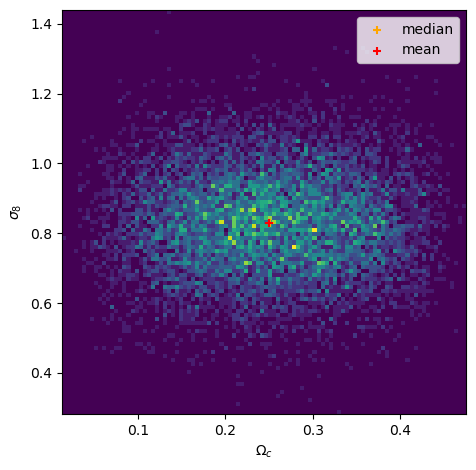

In [35]:
plt.figure()
plt.hist2d(*lat.T, 100)
labels = ['$'+config['prior_config'][name][0]+'$' for name in lat_name]
plt.xlabel(labels[0]), plt.ylabel(labels[1])
plt.scatter(*np.mean(lat, axis=0), marker='+', color='orange', label="median")
plt.scatter(*np.median(lat, axis=0), marker='+', color='r', label="mean")
plt.gca().set_box_aspect(1.0)
plt.tight_layout(), plt.legend()
print(f"obs mean:{obs.mean()}, std:{obs.std()}")
print(f"q5:{jnp.quantile(obs, q=.05)}, q95:{jnp.quantile(obs, q=.95)}")
print(f"max:{obs.max()}, min:{obs.min()}")

## Training a trivial compressor by MSE

In [36]:
# Define our compressor
ResNet4 = partial(resnet.ResNet,
                  n_classes=2,
                  stage_sizes=[2,2],
                  stem_cls=resnet.ResNetStem, block_cls=resnet.ResNetBlock)

class NeuralCompressor(nn.Module):
  @nn.compact
  def __call__(self, x):
    return ResNet4()(x)

In [37]:
# Let's instantiate and initialize the model
compressor = NeuralCompressor()
comp_params = compressor.init(jr.key(42), jnp.zeros(shape=[1,*x_train[0].shape]))

# Define a scheduler for the learning rate
total_steps = 10_000
# total_steps = 1_000
lr_scheduler = optax.piecewise_constant_schedule(init_value=0.001,
                  boundaries_and_scales={int(total_steps*0.3):0.2,
                                         int(total_steps*0.6):0.1,})

# Initializes an optimizer and optimizer state
optimizer = optax.adam(learning_rate=lr_scheduler)
opt_state = optimizer.init(comp_params)

# summary_writer = tensorboard.SummaryWriter('logs/mse')
# tree_map(lambda x: x.shape, params)

In [38]:
# Define a simple MSE regression loss
def loss_fn(params, batch):
    return jnp.mean(jnp.sum((compressor.apply(params, batch['x']) - batch['y'])**2, axis=-1))

@jit
def update_compressor(params, opt_state, batch):
  # Computes the gradients of the model
  loss, grads = value_and_grad(loss_fn)(params, batch)

  # Computes the weights updates and apply them
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return params, opt_state, loss

def noise(key, x):
    return x + obs_std * jr.normal(key,  x.shape)

@partial(jit, static_argnames="batch_size")
def choice_and_noise(key, x, y, batch_size):
  choice_key, noise_key  = jr.split(key, 2)
  inds = jr.choice(choice_key, jnp.arange(len(x)), (batch_size,))
  
  batch = {'x':noise(noise_key, x[inds]), 'y':y[inds]}
  return batch

In [39]:
losses = []
test_losses = []

for i in tqdm.tqdm(range(total_steps), mininterval=1):
  # Train update and loss
  key, seed = jr.split(seed)
  batch = choice_and_noise(key, x_train, y_train, 256)
  comp_params, opt_state, loss = update_compressor(comp_params, opt_state, batch)

  # Test loss
  key, seed = jr.split(seed)
  choice_key, noise_key, seed  = jr.split(seed, 3)
  test_batch = choice_and_noise(key, x_test, y_test, 64)
  test_loss = loss_fn(comp_params, test_batch)

  # Periodically exporting the value of loss function, every 100 steps
  if i % 100 == 0:
     losses.append(loss)
     test_losses.append(test_loss)
    #  summary_writer.scalar('train_loss', loss, i)
    #  summary_writer.scalar('learning_rate', lr_scheduler(i), i)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [09:01<00:00, 18.48it/s]


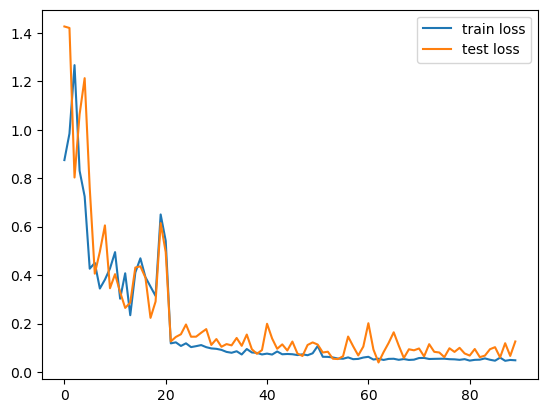

In [40]:
i_toplot = 10
# i_toplot = 1
plt.plot(losses[i_toplot:], label="train loss")
plt.plot(test_losses[i_toplot:], label="test loss")
plt.legend(), plt.show();

In [41]:
# Let's test on the remaining examples
y_pred = compressor.apply(comp_params, noise(jr.key(0), x_test))
loss_fn(comp_params, {'x':noise(noise_key, x_test), 'y':y_test})

Array(0.08746105, dtype=float32)

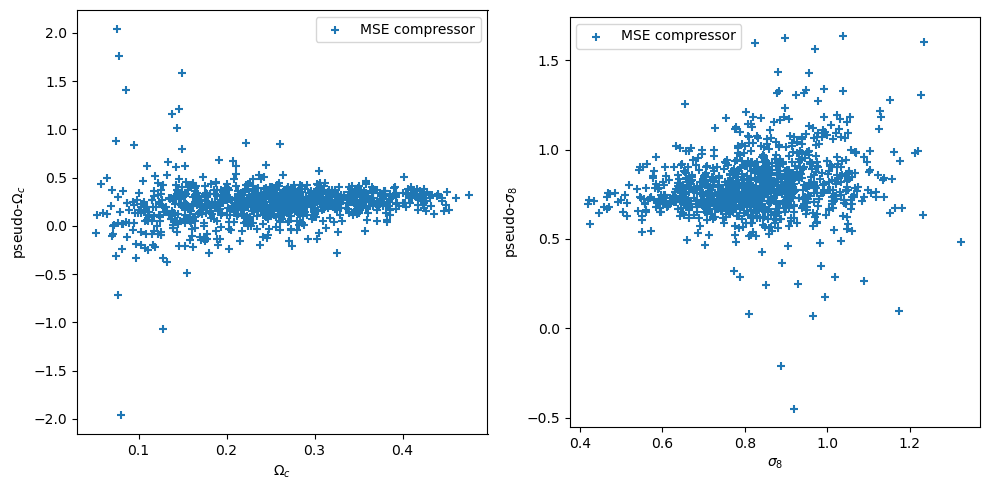

In [42]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(y_test[:,0], y_pred[:,0], marker='+', label='MSE compressor')
plt.xlabel(labels[0]), plt.ylabel("pseudo-"+labels[0])
plt.legend()
plt.subplot(122)
plt.scatter(y_test[:,1], y_pred[:,1], marker='+', label='MSE compressor')
plt.xlabel(labels[1]), plt.ylabel("pseudo-"+labels[1])
plt.legend()
plt.gca().set_box_aspect(1.0), plt.tight_layout()
mlflow.log_figure(plt.gcf(), f"MSE_compression_16.svg")
plt.show();

In [43]:
obs_comp = []
for i in range(len(lat)//1000 + 1):
    key, seed  = jr.split(seed)
    pred = compressor.apply(comp_params, noise(key, obs[i*1000:(i+1)*1000]))
    obs_comp.append(pred)
obs_comp = jnp.concatenate(obs_comp, axis=0)

In [44]:
obs_comp.shape, obs.shape, lat.shape, x_train.shape, y_train.shape

((10000, 2), (10000, 16, 16, 1), (10000, 2), (9000, 16, 16, 1), (9000, 2))

In [45]:
obs_mesh_comp = compressor.apply(comp_params, jnp.mean(fiduc_params['obs_mesh'], axis=-1)[None,...,None])
obs_mesh_comp.shape

(1, 2)

## Performing inference by Neural Posterior Estimation

In [46]:
import tensorflow
import tensorflow_probability
import jax
print(f"{jax.__version__=}")
print(f"{tensorflow.__version__=}")
print(f"{tensorflow_probability.__version__=}")

import tensorflow_probability.substrates.jax as tfp
print("loaded!")

jax.__version__='0.4.25'
tensorflow.__version__='2.16.1'
tensorflow_probability.__version__='0.24.0'
loaded!


In [47]:
# Create neural density estimator (NDE) to approximate p(theta | y)
from sbi_lens.normflow.models import AffineCoupling, ConditionalRealNVP
import jax

n_samples = 100_000

# Affine bijection used in the RealNVP coupling
bijector_npe = partial(
    AffineCoupling,
    layers=[128] * 2,
    activation=jax.nn.silu
)

# Normalizing Flow with 4 RealNVP coupling layers
NF_npe = partial(
  ConditionalRealNVP,
  n_layers=4,
  bijector_fn=bijector_npe
)

# log probability of the NDE
nvp_nd = hk.without_apply_rng(
    hk.transform(
        lambda theta,y : NF_npe(lat.shape[-1])(y).log_prob(theta).squeeze()
    )
)

# sampling of the NDE
nvp_sample_nd = hk.transform(
  lambda y : NF_npe(lat.shape[-1])(y).sample(n_samples, seed=hk.next_rng_key())
)

In [48]:
# init nf params
params = nvp_nd.init(
    jax.random.PRNGKey(42),
    0.5 * jnp.ones([1, obs_comp.shape[-1]]),
    0.5 * jnp.ones([1, obs_comp.shape[-1]])
)

# define optimizer
optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(params)

In [49]:
# negative log likelihood
def loss_nll(params, mu, batch):
    return - jnp.mean(nvp_nd.apply(params, mu, batch))

@jax.jit
def update_nde(params, opt_state, mu, batch):
    """Single SGD update step."""
    loss, grads  = jax.value_and_grad(loss_nll)(
        params,
        mu,
        batch,
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

In [50]:
# training
nde_losses = []
pbar = tqdm.tqdm(range(10_000))

for batch in pbar:
  # thetas = prior(num_samples=256)
  # xs = simulator(thetas)
  batch = choice_and_noise(key, obs_comp, lat, 1024)

  loss, params, opt_state = update_nde(
      params,
      opt_state,
      batch['x'],
      batch['y'],
  )
  nde_losses.append(loss)
  pbar.set_description(f"loss {loss:.3f}")

loss -0.930: 100%|██████████| 10000/10000 [00:18<00:00, 540.35it/s]


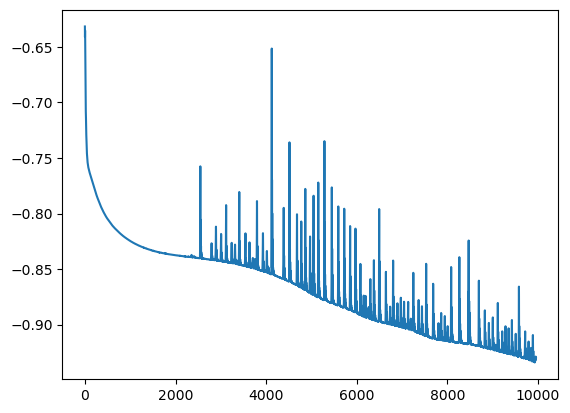

In [51]:
plt.plot(nde_losses[50:])

## Compare MCMC and variational

In [52]:
# from chainconsumer import ChainConsumer
# i_toplot = 0
# # fiduc = tree_map(lambda x:x[i_toplot], simus)
# fiduc = {'Omega_c':lat[i_toplot,0], "sigma8":lat[i_toplot,1]}
# observed = obs_comp[i_toplot]

# plot infered params
samples_nde = nvp_sample_nd.apply(
      params,
      rng = jax.random.PRNGKey(43),
      y = jnp.broadcast_to(obs_mesh_comp, (n_samples, obs_comp.shape[-1]))
)

# c = ChainConsumer()
# c.add_chain(reference_samples, shade_alpha = 0.5, name='Truth')
# c.add_chain(sample_nd,  shade_alpha = 0.5, name='Prediction')
# fig = c.plotter.plot(figsize=1.)

In [53]:
save_path = save_dir + f"NUTS_ns256_standard1."
start_run, end_run = 1,4
# var_names = [name+'_' for name in config['prior_config']] + ['num_steps']
var_names = ["Omega_c_", "sigma8_"] + ['num_steps']
# var_names = None

post_samples_ = load_runs(save_path, start_run, end_run, var_names, conc_axis=[1,0], verbose=True)
post_samples = param_vfn(**post_samples_)

loading: NUTS_ns256_standard1.
total n_samples: (8192,), total n_evals: 8380416


Removed no burn in
Removed no burn in


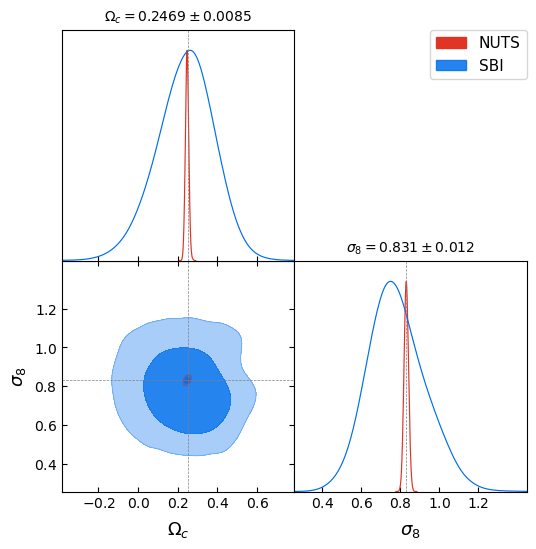

In [54]:
labels = ["\\Omega_c", "\\sigma_8"]
# gdsamp = MCSamples(samples=list(sample_nde.values()), names=list(sample_nde.keys()), labels=labels, label="SBI")
gdsamp_nuts = MCSamples(samples=list(post_samples.values()), names=lat_name, labels=labels, label="NUTS")
gdsamp_nde = MCSamples(samples=samples_nde, names=lat_name, labels=labels, label="SBI")
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(roots=[gdsamp_nuts, gdsamp_nde], title_limit=1, filled=True, markers=fiduc_params)
mlflow.log_figure(plt.gcf(), f"SBI_NUTS_triangle_16.svg")

# With SBI package

In [ ]:
from sbi.inference import SNLE, SNPE_A, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
import torch

In [ ]:
prior = utils.BoxUniform(low=[.15,0.5], high=[0.42,1.25])
inference = SNPE_A(prior=prior)

In [ ]:
inference = inference.append_simulations(torch.tensor(lat[50_000:60_000,:2].to_py()),
                                         torch.tensor(obs_compressed.to_py()))

# Train the density estimator
density_estimator = inference.train()

/usr/local/lib/python3.8/dist-packages/jax/_src/device_array.py:278: FutureWarning: The .to_py() method on JAX arrays is deprecated. Use np.asarray(...) instead.
  warnings.warn("The .to_py() method on JAX arrays is deprecated. Use "


 Neural network successfully converged after 87 epochs.

In [ ]:
# Using the NN to encode one of the diagrams we havent seen before
true_fake =  model.apply(params, poisson(obs[2][jnp.newaxis]))

In [ ]:
posterior = inference.build_posterior(density_estimator)
posterior_samples = posterior.sample((50000,), x=true_fake.to_py().squeeze())

/usr/local/lib/python3.8/dist-packages/jax/_src/device_array.py:278: FutureWarning: The .to_py() method on JAX arrays is deprecated. Use np.asarray(...) instead.
  warnings.warn("The .to_py() method on JAX arrays is deprecated. Use "


Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

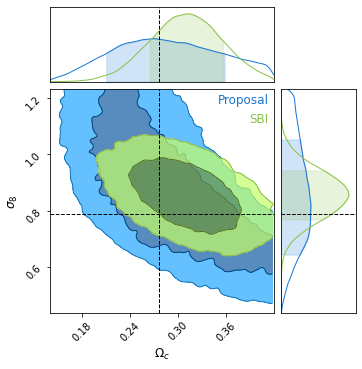

In [ ]:
# For one particular noise realisation
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_chain(lat[:,:2], parameters=["$\Omega_c$", "$\sigma_8$"], name='Proposal')
c.add_chain(posterior_samples.cpu().detach().numpy(), parameters=["$\Omega_c$", "$\sigma_8$"], name='SBI')

fig = c.plotter.plot(figsize="column", truth=lat[2,:2].to_py())